In [1]:
%matplotlib inline
# standard utilities used in the processing
import numpy as np
import os
import pandas as pd
import re
import sys
import time
import xarray as xr

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from matplotlib import pyplot as plt
from tqdm import tqdm

# OOI processing routines
from ooi_data_explorations.common import get_vocabulary, load_gc_thredds, N_CORES, FILL_INT
from ooi_data_explorations.profilers import create_profile_id, bin_profiles
from ooi_data_explorations.uncabled.utilities.utilities_optaa import load_cal_coefficients, apply_dev, apply_tscorr, \
    apply_scatcorr, estimate_chl_poc, calculate_ratios
from pyseas.data.opt_functions import opt_internal_temp, opt_external_temp  # note, use of pyseas will be deprecated once
                                                                            # ION Functions is upgraded to Python 3 in 2024

In [2]:
%%time
# Setup needed parameters for the data request
site = 'CE02SHSP'           # OOI Net site designator
node = 'SP001'              # OOI Net node designator
sensor = '04-OPTAAJ000'     # OOI Net sensor designator
method = 'recovered_cspp'   # OOI Net data delivery method
stream = 'optaa_dj_cspp_instrument_recovered'  # OOI Net stream name
level = 'profiler'          # local directory name, level below site
instrmt = 'optaa'           # local directory name, instrument below level
deploy = 19
tag = 'deployment{:04d}.*OPTAA.*\\.nc$'.format(deploy)  # regex tag to select only OPTAA files from Deployment 19

# download the data from the OOI GC THREDDS server as an xarray dataset
ds = load_gc_thredds(site, node, sensor, method, stream, tag)

Merging the data files into a single dataset
CPU times: user 1.75 s, sys: 432 ms, total: 2.18 s
Wall time: 3.5 s


In [3]:
# review the data loaded from the OOI GC THREDDS catalog
ds

<xarray.Dataset> Size: 212MB
Dimensions:                       (time: 101549, wavelength: 83)
Coordinates:
  * wavelength                    (wavelength) int32 332B 0 1 2 3 ... 80 81 82
  * time                          (time) datetime64[ns] 812kB 2021-04-06T17:2...
Data variables: (12/27)
    external_temp_raw             (time) uint16 203kB 40662 40661 ... 39374
    c_signal_counts               (time, wavelength) uint16 17MB 630 ... 5762
    deployment                    (time) int32 406kB 19 19 19 19 ... 19 19 19 19
    a_signal_counts               (time, wavelength) uint16 17MB 900 ... 8157
    lat                           (time) float64 812kB 44.64 44.64 ... 44.64
    int_ctd_pressure              (time) float64 812kB 76.28 76.23 ... 0.9318
    ...                            ...
    a_signal_dark_counts          (time) uint16 203kB 689 689 689 ... 691 691
    c_reference_counts            (time, wavelength) uint16 17MB 740 ... 8442
    a_reference_dark_counts       (time) uint16 203kB 457 457 457 ... 457 456
    suspect_timestamp             (time) int8 102kB 0 0 0 1 0 0 ... 0 0 0 0 0 1
    depth                         (time) float64 812kB 75.65 75.6 ... 0.9243
    sea_water_temperature         (time) float64 812kB 8.12 8.12 ... 11.56 11.56
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.30115
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [4]:
%%time
# check to see if there is more than one deployment in the data set (strict requirement, cannot process combined deployments
# due to differences in the number of wavelengths and unique calibration data).
if len(np.unique(ds['deployment'].values)) > 1:
    raise ValueError('More than one deployment in the data set.  Please structure processing request to process '
                     'one deployment at a time.')

# drop some of the variables:
#   internal_timestamp == time, redundant so can remove
#   profiler_timestamp == internal_timestamp == time, redundant so can remove
#   suspect_timestamp = not used
#   pressure_counts == none of the OOI OPTAAs have a pressure sensor
ds = ds.drop_vars(['internal_timestamp', 'profiler_timestamp', 'suspect_timestamp', 'pressure_counts'])

# check for data from a co-located CTD, if not present create the variables using NaN's as the fill value
if 'sea_water_temperature' not in ds.variables:
    ds['sea_water_temperature'] = ('time', ds['deployment'].data * np.nan)
    ds['sea_water_practical_salinity'] = ('time', ds['deployment'].data * np.nan)

# pull out the number of wavelengths and serial number and then drop num_wavelengths variable (will be added to metadata)
num_wavelengths = ds.num_wavelengths.values[0].astype(int)
serial_number = int(re.sub('[^0-9]', '', ds.attrs['SerialNumber']))
ds = ds.drop_vars('num_wavelengths')

# remove the units from the variable names
rename = {
    'a_signal_dark_counts': 'a_signal_dark',
    'a_reference_dark_counts': 'a_reference_dark',
    'a_signal_counts': 'a_signal',
    'a_reference_counts': 'a_reference',
    'c_signal_dark_counts': 'c_signal_dark',
    'c_reference_dark_counts': 'c_reference_dark',
    'c_signal_counts': 'c_signal',
    'c_reference_counts': 'c_reference',
    'on_seconds': 'elapsed_run_time',
    'int_ctd_pressure': 'sea_water_pressure',
    'wavelength': 'wavelength_number'
}
ds = ds.rename(rename)

# convert the elapsed_run_time to milliseconds to match all other AC-S datasets
ds['elapsed_run_time'] = ds['elapsed_run_time'] * 1000

CPU times: user 2.29 ms, sys: 77 μs, total: 2.37 ms
Wall time: 2.08 ms


In [5]:
# review the dataset after inital cleaning
ds

<xarray.Dataset> Size: 210MB
Dimensions:                       (time: 101549, wavelength_number: 83)
Coordinates:
  * wavelength_number             (wavelength_number) int32 332B 0 1 2 ... 81 82
  * time                          (time) datetime64[ns] 812kB 2021-04-06T17:2...
Data variables: (12/22)
    external_temp_raw             (time) uint16 203kB 40662 40661 ... 39374
    c_signal                      (time, wavelength_number) uint16 17MB 630 ....
    deployment                    (time) int32 406kB 19 19 19 19 ... 19 19 19 19
    a_signal                      (time, wavelength_number) uint16 17MB 900 ....
    lat                           (time) float64 812kB 44.64 44.64 ... 44.64
    sea_water_pressure            (time) float64 812kB 76.28 76.23 ... 0.9318
    ...                            ...
    c_signal_dark                 (time) uint16 203kB 702 702 703 ... 706 707
    a_signal_dark                 (time) uint16 203kB 689 689 689 ... 691 691
    c_reference                   (time, wavelength_number) uint16 17MB 740 ....
    a_reference_dark              (time) uint16 203kB 457 457 457 ... 457 456
    depth                         (time) float64 812kB 75.65 75.6 ... 0.9243
    sea_water_temperature         (time) float64 812kB 8.12 8.12 ... 11.56 11.56
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.30115
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [6]:
%%time
# set up the calibration file path and name (will store these for later reuse)
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

# load the calibration coefficients
uid = ds.attrs['AssetUniqueID']
start_time = ds['time'][0].values.astype(float) / 10 ** 9
cal = load_cal_coefficients(cal_file, uid, start_time)

# check the calibration coefficients against the deployment data
if cal.coeffs['serial_number'] != serial_number:
    raise Exception('Serial Number mismatch between ac-s data and the device file.')
if cal.coeffs['num_wavelengths'] != num_wavelengths:
    raise Exception('Number of wavelengths mismatch between ac-s data and the device file.')

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 114 ms


In [7]:
# review the calibration data
cal.coeffs

{'a_offsets': array([ 0.492155,  0.566451,  0.625848,  0.67317 ,  0.711699,  0.747972,
         0.78336 ,  0.814832,  0.844638,  0.876427,  0.906457,  0.936035,
         0.965321,  0.994832,  1.024699,  1.054943,  1.085137,  1.113145,
         1.142361,  1.170271,  1.196782,  1.223392,  1.249494,  1.274077,
         1.297169,  1.319602,  1.339597,  1.360275,  1.381022,  1.401852,
         1.422865,  1.443653,  1.463198,  1.481563,  1.499367,  1.516701,
         1.533945,  1.550834,  1.566246,  1.58092 ,  1.594022,  1.604508,
         1.610942,  1.611868,  1.613708,  1.611425,  1.60515 ,  1.593414,
         1.577926,  1.56744 ,  1.564711,  1.56884 ,  1.577708,  1.587351,
         1.595603,  1.604986,  1.613315,  1.620651,  1.626732,  1.630446,
         1.63104 ,  1.627308,  1.622125,  1.619696,  1.620921,  1.623217,
         1.624435,  1.621744,  1.613721,  1.599837,  1.575063,  1.539761,
         1.492067,  1.42994 ,  1.348753,  1.249106,  1.124883,  0.968807,
         0.777474,  0.555

In [8]:
%%time
# Delete the first 45 seconds of the data record per recommendation from the vendor. Note, originally the vendor
# recommended deleting the first 45 seconds, then 60 seconds and then 120 seconds.  They never provided a data
# based reason for the change in recommendation. Within OOI, instruments were programmed to run for 60 seconds,
# then 120 seconds and then 240 seconds ... and it is all mixed up across the various data sets.  So, we are
# going to use the 45-second recommendation and apply it to all data sets. If the vendor ever provides an analysis
# justifying the change in recommendation, we can revisit this.
ds.elapsed_run_time.values = ds.elapsed_run_time.where(ds.elapsed_run_time / 1000 > 45)
ds = ds.dropna(dim='time', subset=['elapsed_run_time'])

# convert internal and external temperature sensors from raw counts to degrees Celsius
ds['internal_temp'] = opt_internal_temp(ds['internal_temp_raw'])
ds['external_temp'] = opt_external_temp(ds['external_temp_raw'])

# create a profile variable to uniquely identify profiles within the dataset
print('Creating and adding a profile variable to the data set ...')
ds = create_profile_id(ds)

# group the data by profile number and bin the data into 25 cm depth bins (nominal ascent rate of the CSPP)
vocab = get_vocabulary(ds.attrs['subsite'], ds.attrs['node'], ds.attrs['sensor'])[0]
site_depth = vocab['maxdepth'] - 2
profiles = ds.groupby('profile')
profiles = [profile[1] for profile in profiles]
partial_binning = partial(bin_profiles, site_depth=site_depth, bin_size=0.25)
with ProcessPoolExecutor(max_workers=N_CORES) as executor:
    binned = list(tqdm(executor.map(partial_binning, profiles), total=len(profiles),
                       desc='Smoothing and binning each profile into 25 cm depth bins', file=sys.stdout))

# reset the dataset now using binned profiles
binned = [i for i in binned if i is not None]
binned = xr.concat(binned, 'time')
binned = binned.sortby(['profile', 'time'])

# confirm dimension order is correct for the wavelength arrays (sometimes the order gets flipped
# during the binning process)
binned['wavelength_a'] = binned.wavelength_a.transpose(*['time', 'wavelength_number'])
binned['wavelength_c'] = binned.wavelength_c.transpose(*['time', 'wavelength_number'])

Creating and adding a profile variable to the data set ...
Smoothing and binning each profile into 25 cm depth bins: 100%|██████████| 76/76 [00:15<00:00,  4.86it/s]
CPU times: user 1.06 s, sys: 456 ms, total: 1.52 s
Wall time: 16.7 s


In [9]:
%%time
# re-process the raw data in order to create the intermediate variables, correcting for the holographic
# grating, applying the temperature and salinity corrections and applying a baseline scatter correction
# to the absorption data. All intermediate processing outputs are added to the data set.
binned = apply_dev(binned, cal.coeffs)
binned = apply_tscorr(binned, cal.coeffs, binned.sea_water_temperature, binned.sea_water_practical_salinity)
binned = apply_scatcorr(binned, cal.coeffs)

# add the jump offsets as NaN's if the grating index correction was not used
if 'a_jump_offsets' not in ds.variables:
    binned['a_jump_offsets'] = ('time', binned['deployment'].data * np.nan)
    binned['c_jump_offsets'] = ('time', binned['deployment'].data * np.nan)

# estimate chlorophyll and POC and calculate select absorption ratios
binned = estimate_chl_poc(binned, cal.coeffs, chl_line_height=0.020)
binned = calculate_ratios(binned)

Converting attenuation data ...: 100%|██████████| 19380/19380 [00:02<00:00, 6922.46it/s]


CPU times: user 5.7 s, sys: 34.2 ms, total: 5.73 s
Wall time: 5.72 s


In [10]:
%%time
# create a xarray dataset of the 2D variables, padding the number of wavelengths to a consistent
# length of 100 using fill values.
wavelength_number = np.arange(100).astype(int)  # used as a dimensional variable
pad = 100 - num_wavelengths
fill_nan = np.tile(np.ones(pad) * np.nan, (len(binned.time), 1))
fill_int = np.tile(np.ones(pad) * FILL_INT, (len(binned.time), 1))

wavelength_a = np.concatenate([binned.wavelength_a.values, fill_nan], axis=1)
wavelength_c = np.concatenate([binned.wavelength_c.values, fill_nan], axis=1)

ac = xr.Dataset({
    'wavelength_a': (['time', 'wavelength_number'], wavelength_a),
    'a_signal': (['time', 'wavelength_number'], np.concatenate([binned.a_signal, fill_int], axis=1).astype(int)),
    'a_reference': (['time', 'wavelength_number'], np.concatenate([binned.a_reference, fill_int],
                                                                  axis=1).astype(int)),
    'optical_absorption': (['time', 'wavelength_number'], np.concatenate([binned.optical_absorption, fill_nan],
                                                                         axis=1)),
    'apg': (['time', 'wavelength_number'], np.concatenate([binned.apg, fill_nan], axis=1)),
    'apg_ts': (['time', 'wavelength_number'], np.concatenate([binned.apg_ts, fill_nan], axis=1)),
    'apg_ts_s': (['time', 'wavelength_number'], np.concatenate([binned.apg_ts_s, fill_nan], axis=1)),
    'wavelength_c': (['time', 'wavelength_number'], wavelength_c),
    'c_signal': (['time', 'wavelength_number'], np.concatenate([binned.c_signal, fill_int], axis=1).astype(int)),
    'c_reference': (['time', 'wavelength_number'], np.concatenate([binned.c_reference, fill_int],
                                                                  axis=1).astype(int)),
    'beam_attenuation': (['time', 'wavelength_number'], np.concatenate([binned.beam_attenuation, fill_nan],
                                                                       axis=1)),
    'cpg': (['time', 'wavelength_number'], np.concatenate([binned.cpg, fill_nan], axis=1)),
    'cpg_ts': (['time', 'wavelength_number'], np.concatenate([binned.cpg_ts, fill_nan], axis=1)),
}, coords={'time': (['time'], binned.time.values), 'wavelength_number': wavelength_number})

# drop the original 2D variables from the binned data set
drop = binned.drop_vars(['wavelength_number', 'wavelength_a', 'a_signal', 'a_reference',
                    'optical_absorption', 'apg', 'apg_ts', 'apg_ts_s',
                    'wavelength_c', 'c_signal', 'c_reference',
                    'beam_attenuation', 'cpg', 'cpg_ts'])

# reset the data type for the 'a' and 'c' signal and reference dark values, and the other raw parameters
int_arrays = ['a_signal_dark', 'a_reference_dark', 'c_signal_dark', 'c_reference_dark',
              'internal_temp_raw', 'external_temp_raw', 'deployment', 'profile']
for k in drop.variables:
    if k in int_arrays:
        drop[k] = drop[k].astype(int)

# recombine the two datasets
optaa = xr.merge([drop, ac])

# reset the attributes, which the merging drops
optaa.attrs = binned.attrs
for v in optaa.variables:
    optaa[v].attrs = binned[v].attrs

CPU times: user 61.3 ms, sys: 20 ms, total: 81.3 ms
Wall time: 80.2 ms


In [11]:
%%time
# reset the variable level attributes and set some global defaults
ATTRS = dict({
    # parsed (raw) variables and attributes
    'serial_number': {
        'long_name': 'Unit Serial Number',
        # 'units': ''    # deliberately left blank, no units for this value
        'comment': ('Instrument serial number, useful for tracking history of instrument through deployments and '
                    'to make sure the correct calibration coefficients have been applied.')
    },
    'external_temp_raw': {
        'long_name': 'Raw In-Situ Temperature',
        'units': 'count',
        'data_product_identifier': 'OPTTEMP_L0',
        'comment': ('Raw measurements, reported in counts, from the AC-S external temperature sensor. This sensor '
                    'measures the in-situ seawater temperature.')
    },
    'internal_temp_raw': {
        'long_name': 'Raw Internal Instrument Temperature',
        'units': 'count',
        'comment': ('Raw measurements, reported in counts, from the AC-S internal temperature sensor. This sensor '
                    'measures the internal instrument temperature and is used in converting the raw optical '
                    'measurements into absorbance and attenuation estimates.')
    },
    'elapsed_run_time': {
        'long_name': 'Elapsed Run Time',
        'units': 'ms',
        'comment': 'Time in milliseconds since the instrument was powered on.'
    },
    'wavelength_number': {
        'long_name': 'Wavelength Number',
        'units': 'count',
        'comment': ('An index counter between 0 and 99 used to set a common length dimension for the absorbance and '
                    'attenuation measurements. The actual number of wavelengths is variable between sensors '
                    'and may even change for a particular sensor over time if servicing requires a replacement '
                    'of the filter set. The actual number of wavelengths for this sensor is represented here '
                    'by the attribute actual_wavelengths.')
        # 'actual_wavelengths': ''  # deliberately left blank, created during the processing
    },
    'wavelength_a': {
        'long_name': 'Absorption Channel Wavelengths',
        'standard_name': 'radiation_wavelength',
        'units': 'nm',
        'comment': ('Absorbance channel measurement wavelengths, specific to the filter wheel set installed in '
                    'the AC-S.'),
        '_FillValue': np.nan
    },
    'a_reference_dark': {
        'long_name': 'Absorption Channel Dark Reference',
        'units': 'count',
        'comment': ('Absorption channel reference detector dark counts (before the lamp is turned on). Used in '
                    'conversion of the raw absorption channel measurements to absorbance estimates.')
    },
    'a_reference': {
        'long_name': 'Absorption Channel Reference Measurements',
        'units': 'count',
        'comment': ('Absorption channel reference detector raw counts (while the lamp is turned on). Used in '
                    'conversion of the raw absorption channel measurements to absorbance estimates.'),
        'data_product_identifier': 'OPTAREF_L0',
        '_FillValue': FILL_INT
    },
    'a_signal_dark': {
        'long_name': 'Absorption Channel Dark Signal',
        'units': 'count',
        'comment': ('Absorption channel signal detector dark counts (before the lamp is turned on). Used in conversion '
                    'of the raw absorption channel measurements to absorbance estimates.')
    },
    'a_signal': {
        'long_name': 'Absorption Channel Signal Measurements',
        'units': 'count',
        'comment': ('Absorption channel signal detector raw counts (while the lamp is turned on). Used in conversion '
                    'of the raw absorption channel measurements to absorbance estimates.'),
        'data_product_identifier': 'OPTASIG_L0',
        '_FillValue': FILL_INT
    },
    'wavelength_c': {
        'long_name': 'Attenuation Channel Wavelengths',
        'standard_name': 'radiation_wavelength',
        'units': 'nm',
        'comment': ('Attenuation channel measurement wavelengths, specific to the filter wheel set installed in '
                    'the AC-S.'),
        '_FillValue': np.nan
    },
    'c_reference_dark': {
        'long_name': 'Attenuation Channel Dark Reference',
        'units': 'count',
        'comment': ('Attenuation channel reference detector dark counts (before the lamp is turned on). Used in '
                    'conversion of the raw attenuation channel measurements to attenuation estimates.')
    },
    'c_reference': {
        'long_name': 'Attenuation Channel Reference Measurements',
        'units': 'count',
        'comment': ('Attenuation channel reference detector raw counts (while the lamp is turned on). Used in '
                    'conversion of the raw attenuation channel measurements to attenuation estimates.'),
        'data_product_identifier': 'OPTCREF_L0',
        '_FillValue': FILL_INT
    },
    'c_signal_dark': {
        'long_name': 'Attenuation Channel Dark Signal',
        'units': 'count',
        'comment': ('Attenuation channel signal detector dark counts (before the lamp is turned on). Used in '
                    'conversion of the raw attenuation channel measurements to attenuation estimates.')
    },
    'c_signal': {
        'long_name': 'Attenuation Channel Signal Measurements',
        'units': 'count',
        'comment': ('Attenuation channel signal detector raw counts (while the lamp is turned on). Used in conversion '
                    'of the raw attenuation channel measurements to attenuation estimates.'),
        'data_product_identifier': 'OPTCSIG_L0',
        '_FillValue': FILL_INT
    },

    # Data from a co-located CTD, if available, interpolated into the data set
    'sea_water_temperature': {
        'long_name': 'Seawater Temperature',
        'standard_name': 'sea_water_temperature',
        'units': 'degree_Celsius',
        'comment': ('Sea water temperature is the in situ temperature of the sea water near the sensor. Measurements '
                    'are from a co-located CTD'),
        'data_product_identifier': 'TEMPWAT_L1',
        '_FillValue': np.nan
    },
    'sea_water_practical_salinity': {
        'long_name': 'Practical Salinity',
        'standard_name': 'sea_water_practical_salinity',
        'units': '1',
        'comment': ('Salinity is generally defined as the concentration of dissolved salt in a parcel of sea water. '
                    'Practical Salinity is a more specific unit-less quantity calculated from the conductivity of '
                    'sea water and adjusted for temperature and pressure. It is approximately equivalent to Absolute '
                    'Salinity (the mass fraction of dissolved salt in sea water), but they are not interchangeable. '
                    'Measurements are from a co-located CTD.'),
        'data_product_identifier': 'PRACSAL_L2',
        '_FillValue': np.nan
    },
    'sea_water_pressure': {
        'long_name': 'Seawater Pressure',
        'standard_name': 'sea_water_pressure',
        'units': 'dbar',
        'comment': ('Seawater Pressure refers to the pressure exerted on a sensor in situ by the weight of the column '
                    'of seawater above it. It is calculated by subtracting one standard atmosphere from the absolute '
                    'pressure at the sensor to remove the weight of the atmosphere on top of the water column. The '
                    'pressure at a sensor in situ provides a metric of the depth of that sensor. Measurements are from '
                    'a co-located CTD'),
        'data_product_identifier': 'PRESWAT_L1',
        '_FillValue': np.nan
    },

    # OOI calculated beam attenuation and optical absorption
    'beam_attenuation': {
        'long_name': 'Optical Beam Attenuation Coefficient',
        'units': 'm-1',
        'comment': ('The Optical Beam Attenuation Coefficient is the rate that the intensity of a beam of light will '
                    'decrease in response to the combined effects of absorption and scatter as a function of '
                    'propagation distance. The Attenuation Coefficient results from the spectral beam attenuation of '
                    'the combination of all seawater impurities including all particulate and dissolved matter of '
                    'optical importance.'),
        'data_product_identifier': 'OPTATTN_L2',
        'ancillary_variables': ('wavelength_c internal_temp c_signal c_reference c_signal_dark c_reference_dark '
                                'seawater_temperature practical_salinity'),
        '_FillValue': np.nan
    },
    'optical_absorption': {
        'long_name': 'Optical Absorption Coefficient',
        'standard_name': 'volume_absorption_coefficient_of_radiative_flux_in_sea_water',
        'units': 'm-1',
        'comment': ('Optical Absorption Coefficient is the rate that the intensity of a beam of light will decrease '
                    'in response to the absorption (removal) of light energy as a function of propagation distance. '
                    'The Optical Absorption Coefficient reflects the absorption coefficient for the combination of all '
                    'seawater impurities including all particulate and dissolved matter of optical importance.'),
        'data_product_identifier': 'OPTABSN_L2',
        'ancillary_variables': ('wavelength_a internal_temp a_signal a_reference a_signal_dark a_reference_dark '
                                'seawater_temperature practical_salinity'),
        '_FillValue': np.nan
    },

    # Derived values in the re-processed data set
    'external_temp': {
        'long_name': 'External Instrument Temperature',
        'standard_name': 'sea_water_temperature',
        'units': 'degrees_Celsius',
        'comment': ('In-situ sea water temperature measurements from the sensor mounted at the top of the '
                    'AC-S pressure housing.'),
        'ancillary_variables': 'external_temp_raw'
    },
    'internal_temp': {
        'long_name': 'Internal Instrument Temperature',
        'units': 'degrees_Celsius',
        'comment': 'Internal instrument temperature, used to convert raw absorbance and attenuation measurements.',
        'ancillary_variables': 'internal_temp_raw'
    },
    'apg': {
        'long_name': 'Particulate and Dissolved Absorbance',
        'units': 'm-1',
        'comment': ('The optical absorption coefficient is the rate that the intensity of a beam of light will '
                    'decrease in response to the absorption (removal) of light energy as a function of propagation '
                    'distance. The optical absorption coefficient reflects the absorption coefficient for the '
                    'combination of all seawater impurities, including all particulate and dissolved matter of '
                    'optical importance.'),
        'data_product_identifier': 'OPTABSN_L1',
        'ancillary_variables': ('wavelength_a internal_temp a_signal_raw a_reference_raw '
                                'a_signal_dark a_reference_dark'),
        '_FillValue': np.nan
    },
    'a_jump_offsets': {
        'long_name': 'Absorption Channel Holographic Grater Jump Offset',
        'units': 'm-1',
        'comment': ('Offset used to correct for spectral jumps commonly seen in the AC-S data where the sensor uses '
                    'two holographic gratings to span the full spectral range. Adding the offset to all values '
                    'from the grate_index (included as an additional attribute) to the end of the spectra will '
                    'restore the AC-S data to values reported by the sensor.'),
        'grate_index': 0,  # Will update in the processing script
        'ancillary_variables': 'wavelength_a apg',
    },
    'apg_ts': {
        'long_name': 'Particulate and Dissolved Absorbance with TS Correction',
        'units': 'm-1',
        'comment': ('The optical absorption coefficient corrected for the effects of temperature and salinity. '
                    'Utilizes data from a co-located CTD for the temperature and salinity, if available. If no '
                    'co-located CTD data is available, will assume a constant salinity of 33 psu and will use '
                    'the OPTAA''s external temperature sensor.'),
        'ancillary_variables': 'wavelength_a sea_water_temperature sea_water_practical_salinity external_temp apg',
        '_FillValue': np.nan
    },
    'apg_ts_s': {
        'long_name': 'Particulate and Dissolved Absorbance with TS and Scatter Correction',
        'standard_name': 'volume_absorption_coefficient_of_radiative_flux_in_sea_water',
        'units': 'm-1',
        'comment': ('The optical absorption coefficient corrected for scattering after correcting for temperature and '
                    'salinity. Utilizes Method 1 (baseline correction) by subtracting the absorption at 715 nm from '
                    'all values; assumes scattering is flat across wavelengths.'),
        'data_product_identifier': 'OPTABSN_L2',
        'ancillary_variables': 'wavelength_a apg_ts',
        '_FillValue': np.nan
    },
    'cpg': {
        'long_name': 'Particulate and Dissolved Attenuation',
        'units': 'm-1',
        'comment': ('The optical beam attenuation coefficient is the rate that the intensity of a beam of light will '
                    'decrease in response to the combined effects of absorption and scatter as a function of '
                    'propagation distance. The attenuation coefficient results from the spectral beam attenuation of '
                    'the combination of all seawater impurities including all particulate and dissolved matter of '
                    'optical importance.'),
        'data_product_identifier': 'OPTATTN_L1',
        'ancillary_variables': ('wavelength_c internal_temp c_signal_raw c_reference_raw '
                                'c_signal_dark c_reference_dark'),
        '_FillValue': np.nan
    },
    'c_jump_offsets': {
        'long_name': 'Attenuation Channel Filter Offsets',
        'units': 'm-1',
        'comment': ('Offset used to correct for spectral jumps commonly seen in the AC-S data where the sensor uses '
                    'two holographic gratings to span the full spectral range. Adding the offset to all values '
                    'from the grate_index (included as an additional attribute) to the end of the spectra will '
                    'restore the AC-S data to values reported by the sensor.'),
        'grate_index': 0,  # Will update in the processing script
        'ancillary_variables': 'wavelength_c cpg',
    },
    'cpg_ts': {
        'long_name': 'Particulate and Dissolved Attenuation with TS Correction',
        'units': 'm-1',
        'comment': ('The optical beam attenuation coefficient corrected for the effects of temperature and salinity. '
                    'Utilizes data from a co-located CTD for the temperature and salinity, if available. If no '
                    'co-located CTD data is available, will assume a constant salinity of 33 psu and will use '
                    'the OPTAA''s external temperature sensor.'),
        'data_product_identifier': 'OPTATTN_L2',
        'ancillary_variables': 'wavelength_c sea_water_temperature sea_water_practical_salinity external_temp cpg',
        '_FillValue': np.nan
    },
    'estimated_chlorophyll': {
        'long_name': 'Estimated Chlorophyll Concentration',
        'standard_name': 'mass_concentration_of_chlorophyll_in_sea_water',
        'units': 'ug L-1',
        'comment': ('Uses the absorption line height at 676 nm, above a linear background between 650 and 715 nm, with '
                    'a chlorophyll specific absorption of 0.020 L/ug/m to estimate the concentration of chlorophyll. '
                    'This method has been shown to be significantly related to extracted chlorophyll concentrations '
                    'and is robust in response to mild to moderate bio-fouling.'),
        'ancillary_variables': 'apg_ts_s',
        '_FillValue': np.nan
    },
    'estimated_poc': {
        'long_name': 'Estimated POC Concentration',
        'standard_name': 'mass_concentration_of_organic_detritus_expressed_as_carbon_in_sea_water',
        'units': 'ug L-1',
        'comment': ('Uses the particulate beam attenuation coefficient at 660 nm and a coefficient of 380 ug/L/m. This '
                    'calculation is not robust in response to bio-fouling and is expected to breakdown as bio-fouling '
                    'begins to dominate the signal.'),
        'ancillary_variables': 'cpg_ts',
        '_FillValue': np.nan
    },
    'ratio_cdom': {
        'long_name': 'CDOM to Chlorophyll Absorbance Ratio',
        'units': '1',
        'comment': ('Ratio of CDOM absorption in the violet portion of the spectrum at 412 nm relative to '
                    'chlorophyll absorption at 440 nm. Ratios greater than 1 indicate a preponderance of CDOM '
                    'absorption relative to chlorophyll.'),
        'ancillary_variables': 'apg_ts_s',
        '_FillValue': np.nan
    },
    'ratio_carotenoids': {
        'long_name': 'Carotenoid to Chlorophyll Absorbance Ratio',
        'units': '1',
        'comment': ('Ratio of carotenoid absorption in the blue-green portion of the spectrum at 490 nm relative to '
                    'chlorophyll absorption at 440 nm. A changing carotenoid to chlorophyll ratio may indicate a shift '
                    'in phytoplankton community composition in addition to changes in light history or bloom health '
                    'and age.'),
        'ancillary_variables': 'apg_ts_s',
        '_FillValue': np.nan
    },
    'ratio_phycobilins': {
        'long_name': 'Phycobilins to Chlorophyll Absorbance Ratio',
        'units': '1',
        'comment': ('Ratio of phycobilin absorption in the green portion of the spectrum at 530 nm relative to '
                    'chlorophyll absorption at 440 nm. Different phytoplankton, notably cyanobacteria, utilize '
                    'phycobilins as accessory light harvesting pigments. An increasing phycobilin to chlorophyll ratio '
                    'may indicate a shift in phytoplankton community composition.'),
        'ancillary_variables': 'apg_ts_s',
        '_FillValue': np.nan
    },
    'ratio_qband': {
        'long_name': 'Chlorophyll Q Band to Soret Band Absorbance Ratio',
        'units': '1',
        'comment': ('The Soret and the Q bands represent the two main absorption bands of chlorophyll. The former '
                    'covers absorption in the blue region of the spectrum, while the latter covers absorption in the '
                    'red region. A decrease in the ratio of the intensity of the Soret band at 440 nm to that of the Q '
                    'band at 676 nm may indicate a change in phytoplankton community structure. All phytoplankton '
                    'contain chlorophyll a as the primary light harvesting pigment, but green algae and '
                    'dinoflagellates contain chlorophyll b and c, respectively, which are spectrally redshifted '
                    'compared to chlorophyll a.'),
        'ancillary_variables': 'apg_ts_s',
        '_FillValue': np.nan
    }
})

# reset some attributes
for key, value in ATTRS.items():
    for atk, atv in value.items():
        if key in optaa.variables:
            optaa[key].attrs[atk] = atv

# add the original variable name as an attribute, if renamed
for key, value in rename.items():
    optaa[value].attrs['ooinet_variable_name'] = key

# add the actual number of wavelengths to the dataset as an attribute
optaa['wavelength_number'].attrs['actual_wavelengths'] = num_wavelengths

# if the filter index was used to adjust the spectral jumps, add that attribute to the data set
if cal.coeffs['grate_index']:
    optaa['a_jump_offsets'].attrs['grate_index'] = cal.coeffs['grate_index']
    optaa['c_jump_offsets'].attrs['grate_index'] = cal.coeffs['grate_index']

CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 1.57 ms


In [12]:
%%time
# save the data to a local directory
nc_file = ('{}.{}.{}.deploy{:02d}.reprocessed.nc'.format(site.lower(), level, instrmt, deploy))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

# split the data into profiles and look at the data from profile 7
profiles = optaa.groupby('profile')
profile = profiles[6]
profile

CPU times: user 135 ms, sys: 129 ms, total: 264 ms
Wall time: 1.85 s


<xarray.Dataset> Size: 3MB
Dimensions:                       (time: 278, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 2kB 2021-04-06T21:07:...
  * wavelength_number             (wavelength_number) int64 800B 0 1 2 ... 98 99
Data variables: (12/38)
    external_temp_raw             (time) int64 2kB 40668 40668 ... 40115 40115
    deployment                    (time) int64 2kB 19 19 19 19 ... 19 19 19 19
    lat                           (time) float64 2kB 44.64 44.64 ... 44.64 44.64
    sea_water_pressure            (time) float64 2kB 74.08 73.87 ... 4.519 4.347
    lon                           (time) float64 2kB -124.3 -124.3 ... -124.3
    internal_temp_raw             (time) int64 2kB 51229 51225 ... 50968 50967
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 222kB 400...
    c_signal                      (time, wavelength_number) int64 222kB 632 ....
    c_reference                   (time, wavelength_number) int64 222kB 729 ....
    beam_attenuation              (time, wavelength_number) float64 222kB 0.2...
    cpg                           (time, wavelength_number) float64 222kB 0.2...
    cpg_ts                        (time, wavelength_number) float64 222kB 0.2...
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.30115
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

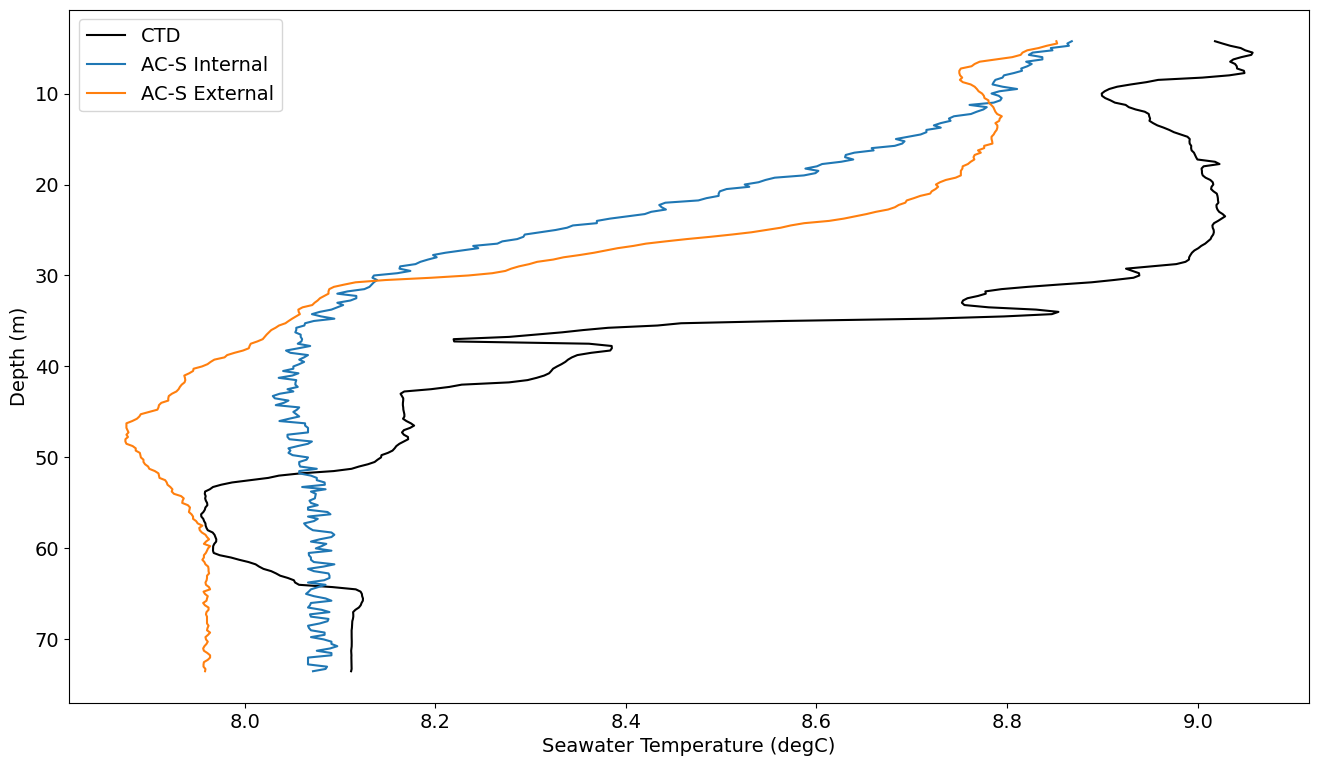

In [13]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 10
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['sea_water_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

In [14]:
%%time
from ooi_data_explorations.uncabled.process_flort import flort_cspp

# Setup needed parameters for the request
sensor = '07-FLORTJ000'     # OOI Net sensor designator
stream = 'flort_sample'     # OOI Net stream name
method = 'recovered_cspp'   # OOI Net data delivery method
instrmt = 'flort'           # local directory name, instrument below level

# load data from the GC THREDDS Catalog
flort = load_gc_thredds(site, node, sensor, method, stream, ('deployment%04d.*FLORT.*\\.nc$' % deploy))
flort = flort_cspp(flort)

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 43317 * (flort['bback'] - flort['sea_water_scattering_coefficient'])  # derived from Cetinic et al., 2012 and references therein

fprofiles = flort.groupby('profile')
fprofile = fprofiles[6]
fprofile

Merging the data files into a single dataset
Creating and adding a profile variable to the data set ...
CPU times: user 1.37 s, sys: 56 ms, total: 1.43 s
Wall time: 1.98 s


<xarray.Dataset> Size: 43kB
Dimensions:                                     (time: 270)
Coordinates:
  * time                                        (time) datetime64[ns] 2kB 202...
Data variables: (12/39)
    estimated_chlorophyll_qc_results            (time) uint8 270B 13 13 ... 29
    fluorometric_cdom                           (time) float64 2kB 0.892 ... ...
    fluorometric_cdom_qc_executed               (time) uint8 270B 29 29 ... 29
    fluorometric_cdom_qartod_results            (time) uint8 270B 1 1 1 ... 1 1
    fluorometric_chlorophyll_a_qartod_results   (time) uint8 270B 3 3 3 ... 1 1
    fluorometric_cdom_qartod_executed           (time) <U1 1kB '1' '1' ... '1'
    ...                                          ...
    estimated_chlorophyll_qc_summary_flag       (time) int32 1kB 3 3 3 ... 1 1 1
    bback_qc_summary_flag                       (time) int32 1kB 3 3 3 ... 1 1 1
    beta_700_qc_summary_flag                    (time) int32 1kB 1 3 3 ... 1 1 1
    sea_water_pressure_qc_summary_flag          (time) int32 1kB 1 1 1 ... 1 1 1
    fluorometric_cdom_qc_summary_flag           (time) int32 1kB 1 1 1 ... 1 1 1
    estimated_poc                               (time) float64 2kB 157.3 ... ...
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             flort_sample
    ...                                 ...
    geospatial_lon_max:                 -124.30115
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

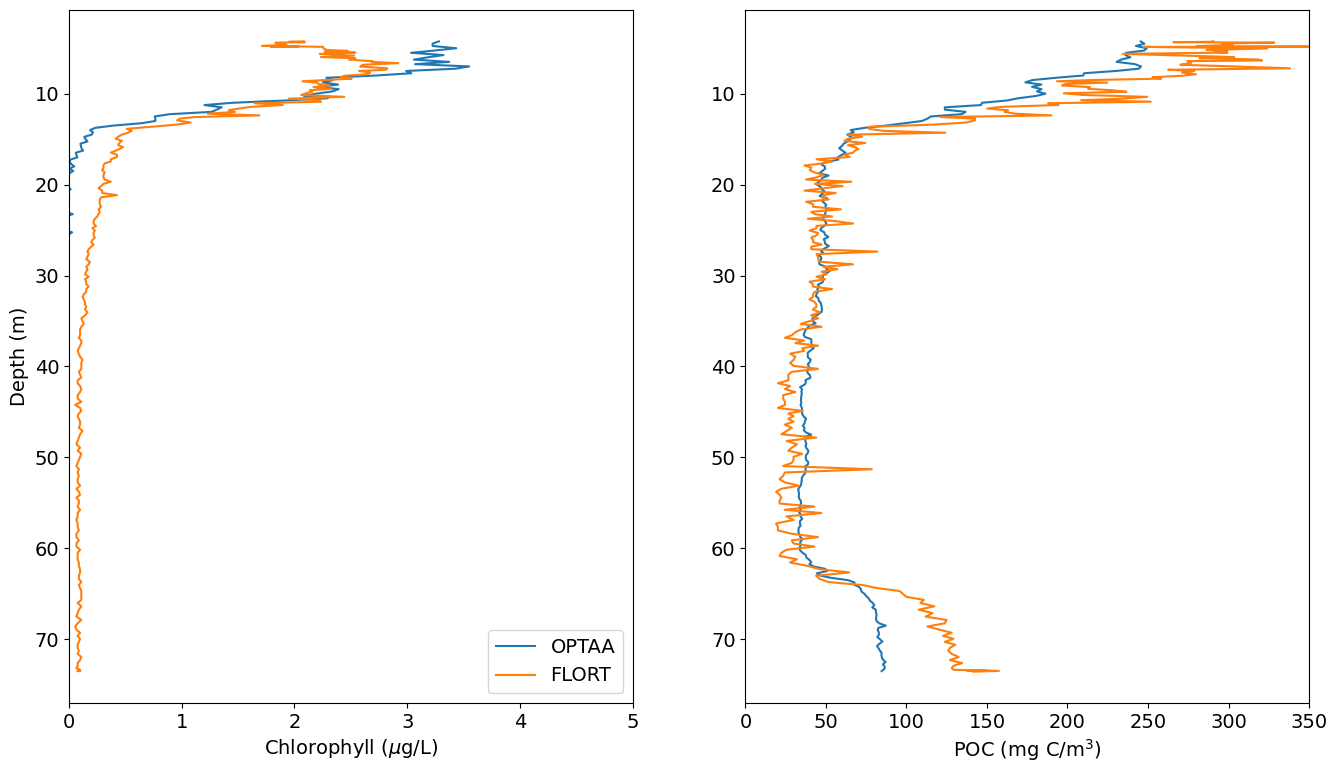

In [15]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'], label='OPTAA')
plt.plot(fprofile['estimated_chlorophyll'], fprofile['depth'], label='FLORT')
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 5])
plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.plot(fprofile['estimated_poc'], fprofile['depth'])
plt.gca().invert_yaxis()
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 350])
plt.show()

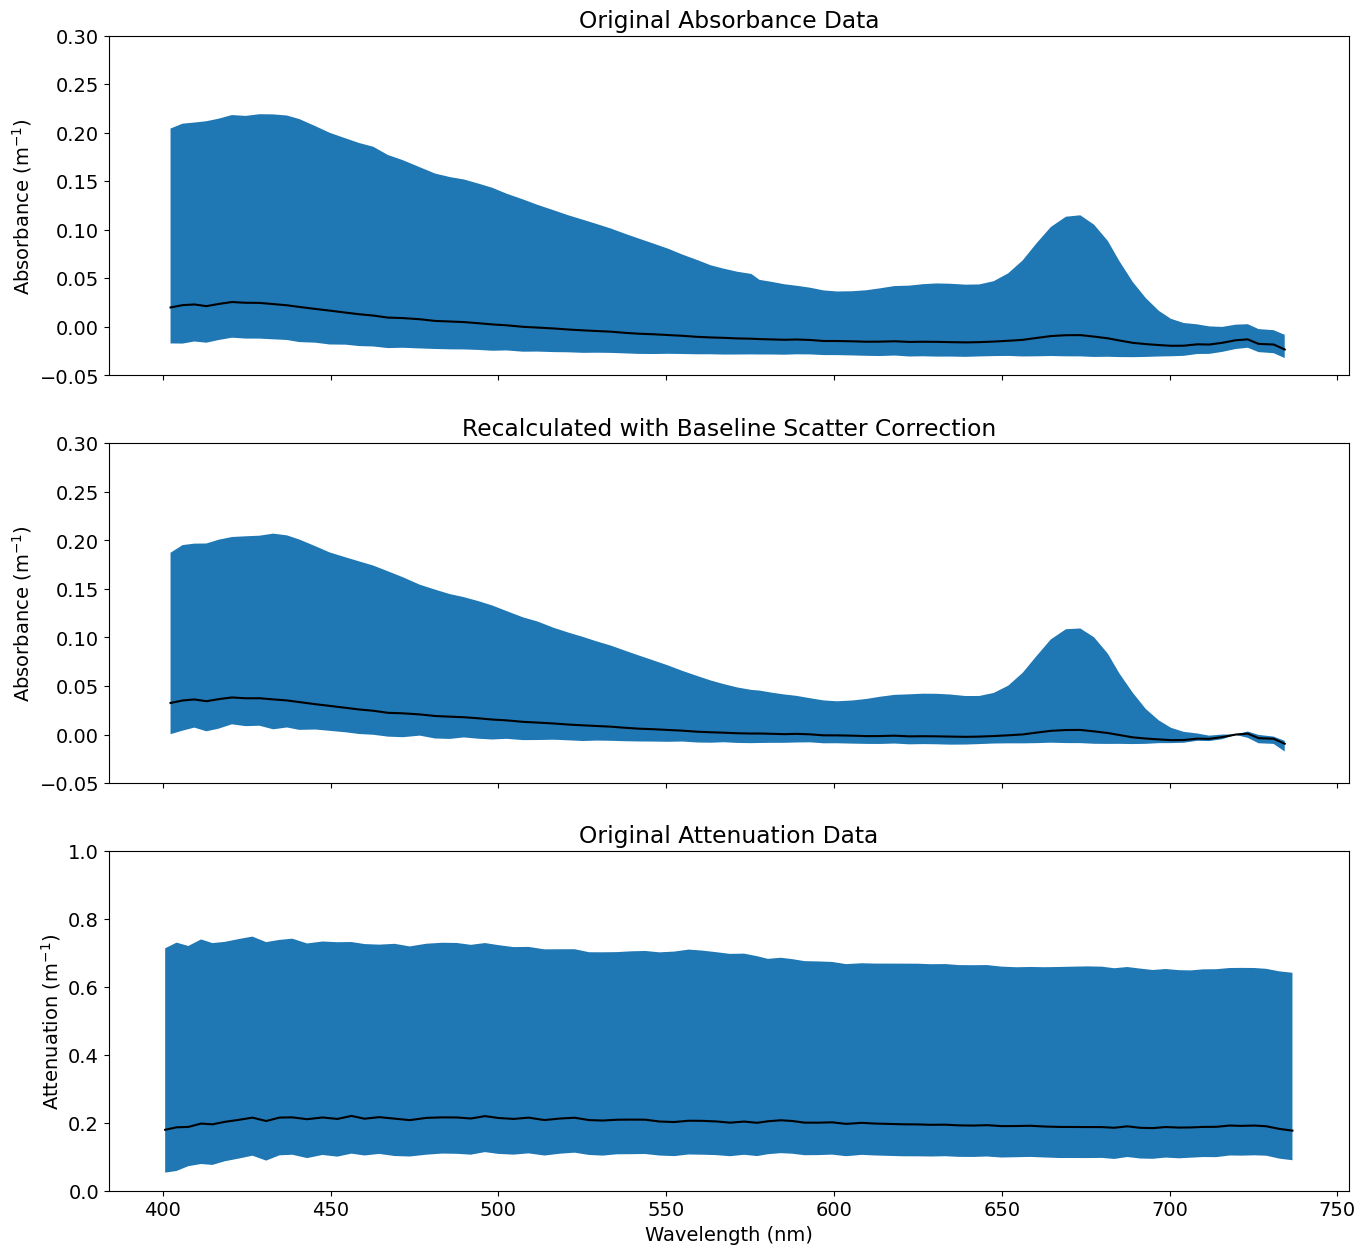

In [16]:
# plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,15))

ax1 = plt.subplot(311)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].max(axis=0))
plt.ylim([-0.05, 0.3])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Original Absorbance Data')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apg_ts_s'].min(axis=0), 
                 profile['apg_ts_s'].max(axis=0))
plt.ylim([-0.05, 0.3])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Recalculated with Baseline Scatter Correction')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].max(axis=0))
plt.ylim([0, 1.0])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.title('Original Attenuation Data')

plt.show()

In [17]:
# load the offsets
aoff = pd.read_csv('acs137_20210302_pre_deployment_adat.csv')
coff = pd.read_csv('acs137_20210302_pre_deployment_cdat.csv')
pre_cal = {}
pre_cal['a'] = aoff['offset_Tcorr'].values
pre_cal['c'] = coff['offset_Tcorr'].values

In [18]:
%%time
# starting back with the binned data, apply the offset corrections to the data and then recalculate 
# the T/S and scatter corrections
binned = apply_dev(binned, cal.coeffs, pre_cal)
binned = apply_tscorr(binned, cal.coeffs, binned.sea_water_temperature, binned.sea_water_practical_salinity)
binned = apply_scatcorr(binned, cal.coeffs)

# estimate chlorophyll and POC and calculate select absorption ratios
binned = estimate_chl_poc(binned, cal.coeffs, chl_line_height=0.025)
binned = calculate_ratios(binned)

# re-create the final dataset
ac = xr.Dataset({
    'wavelength_a': (['time', 'wavelength_number'], wavelength_a),
    'a_signal': (['time', 'wavelength_number'], np.concatenate([binned.a_signal, fill_int], axis=1).astype(int)),
    'a_reference': (['time', 'wavelength_number'], np.concatenate([binned.a_reference, fill_int],
                                                                  axis=1).astype(int)),
    'optical_absorption': (['time', 'wavelength_number'], np.concatenate([binned.optical_absorption, fill_nan],
                                                                         axis=1)),
    'apg': (['time', 'wavelength_number'], np.concatenate([binned.apg, fill_nan], axis=1)),
    'apg_ts': (['time', 'wavelength_number'], np.concatenate([binned.apg_ts, fill_nan], axis=1)),
    'apg_ts_s': (['time', 'wavelength_number'], np.concatenate([binned.apg_ts_s, fill_nan], axis=1)),
    'wavelength_c': (['time', 'wavelength_number'], wavelength_c),
    'c_signal': (['time', 'wavelength_number'], np.concatenate([binned.c_signal, fill_int], axis=1).astype(int)),
    'c_reference': (['time', 'wavelength_number'], np.concatenate([binned.c_reference, fill_int],
                                                                  axis=1).astype(int)),
    'beam_attenuation': (['time', 'wavelength_number'], np.concatenate([binned.beam_attenuation, fill_nan],
                                                                       axis=1)),
    'cpg': (['time', 'wavelength_number'], np.concatenate([binned.cpg, fill_nan], axis=1)),
    'cpg_ts': (['time', 'wavelength_number'], np.concatenate([binned.cpg_ts, fill_nan], axis=1)),
}, coords={'time': (['time'], binned.time.values), 'wavelength_number': wavelength_number})

# drop the original 2D variables from the binned data set
drop = binned.drop_vars(['wavelength_number', 'wavelength_a', 'a_signal', 'a_reference',
                    'optical_absorption', 'apg', 'apg_ts', 'apg_ts_s',
                    'wavelength_c', 'c_signal', 'c_reference',
                    'beam_attenuation', 'cpg', 'cpg_ts'])

# reset the data type for the 'a' and 'c' signal and reference dark values, and the other raw parameters
int_arrays = ['a_signal_dark', 'a_reference_dark', 'c_signal_dark', 'c_reference_dark',
              'internal_temp_raw', 'external_temp_raw', 'deployment', 'profile']
for k in drop.variables:
    if k in int_arrays:
        drop[k] = drop[k].astype(int)

# recombine the two datasets
optaa = xr.merge([drop, ac])

# reset the attributes, which the merging drops
optaa.attrs = binned.attrs
for v in optaa.variables:
    optaa[v].attrs = binned[v].attrs

# reset some attributes
for key, value in ATTRS.items():
    for atk, atv in value.items():
        if key in optaa.variables:
            optaa[key].attrs[atk] = atv

# add the original variable name as an attribute, if renamed
for key, value in rename.items():
    optaa[value].attrs['ooinet_variable_name'] = key

# add the actual number of wavelengths to the dataset as an attribute
optaa['wavelength_number'].attrs['actual_wavelengths'] = num_wavelengths

# if the filter index was used to adjust the spectral jumps, add that attribute to the data set
if cal.coeffs['grate_index']:
    optaa['a_jump_offsets'].attrs['grate_index'] = cal.coeffs['grate_index']
    optaa['c_jump_offsets'].attrs['grate_index'] = cal.coeffs['grate_index']
    
# re-process data into profiles
profiles = optaa.groupby('profile')
profile = profiles[6]

Converting attenuation data ...: 100%|██████████| 19380/19380 [00:02<00:00, 6902.64it/s]


CPU times: user 5.84 s, sys: 107 ms, total: 5.95 s
Wall time: 5.94 s


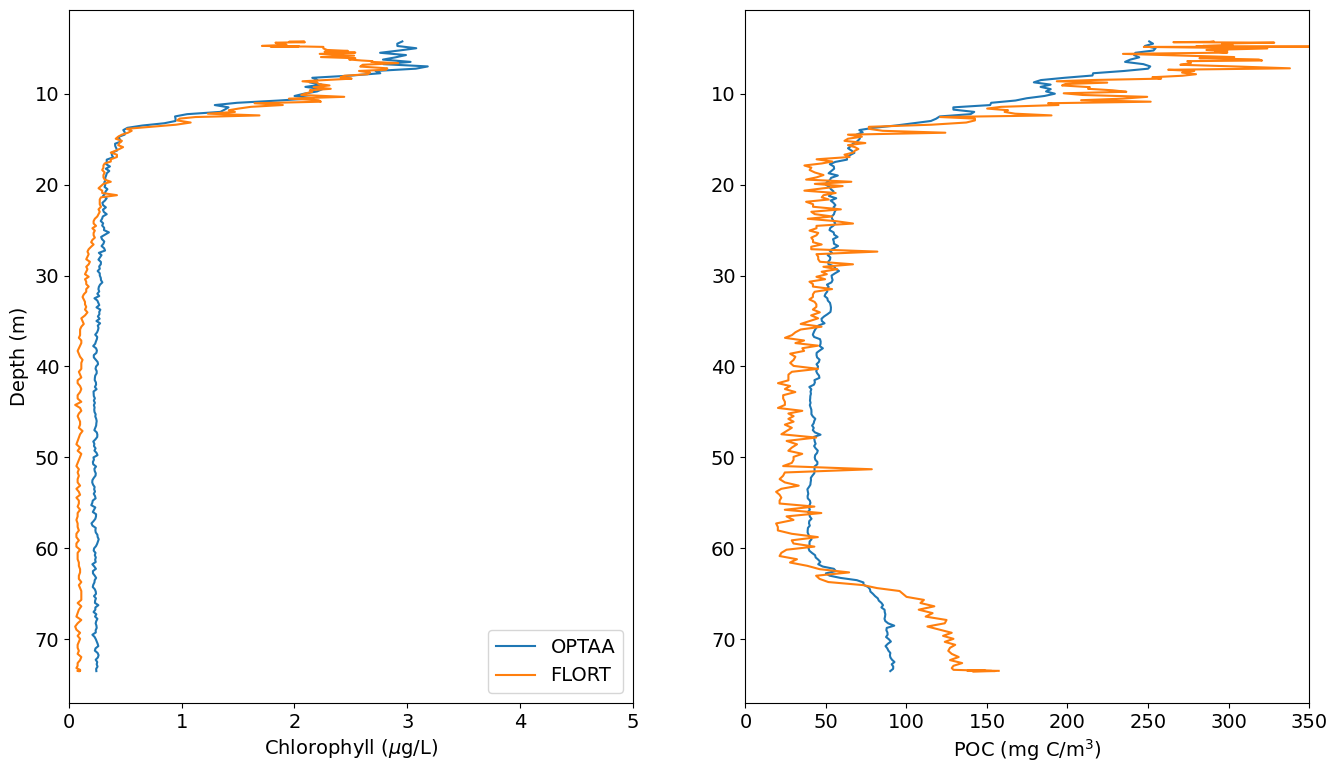

In [19]:
# re-plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
profile = profiles[6]
ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'], label='OPTAA')
plt.plot(fprofile['estimated_chlorophyll'], fprofile['depth'], label='FLORT')
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 5])
plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.plot(fprofile['estimated_poc'], fprofile['depth'])
plt.gca().invert_yaxis()
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 350])
plt.show()

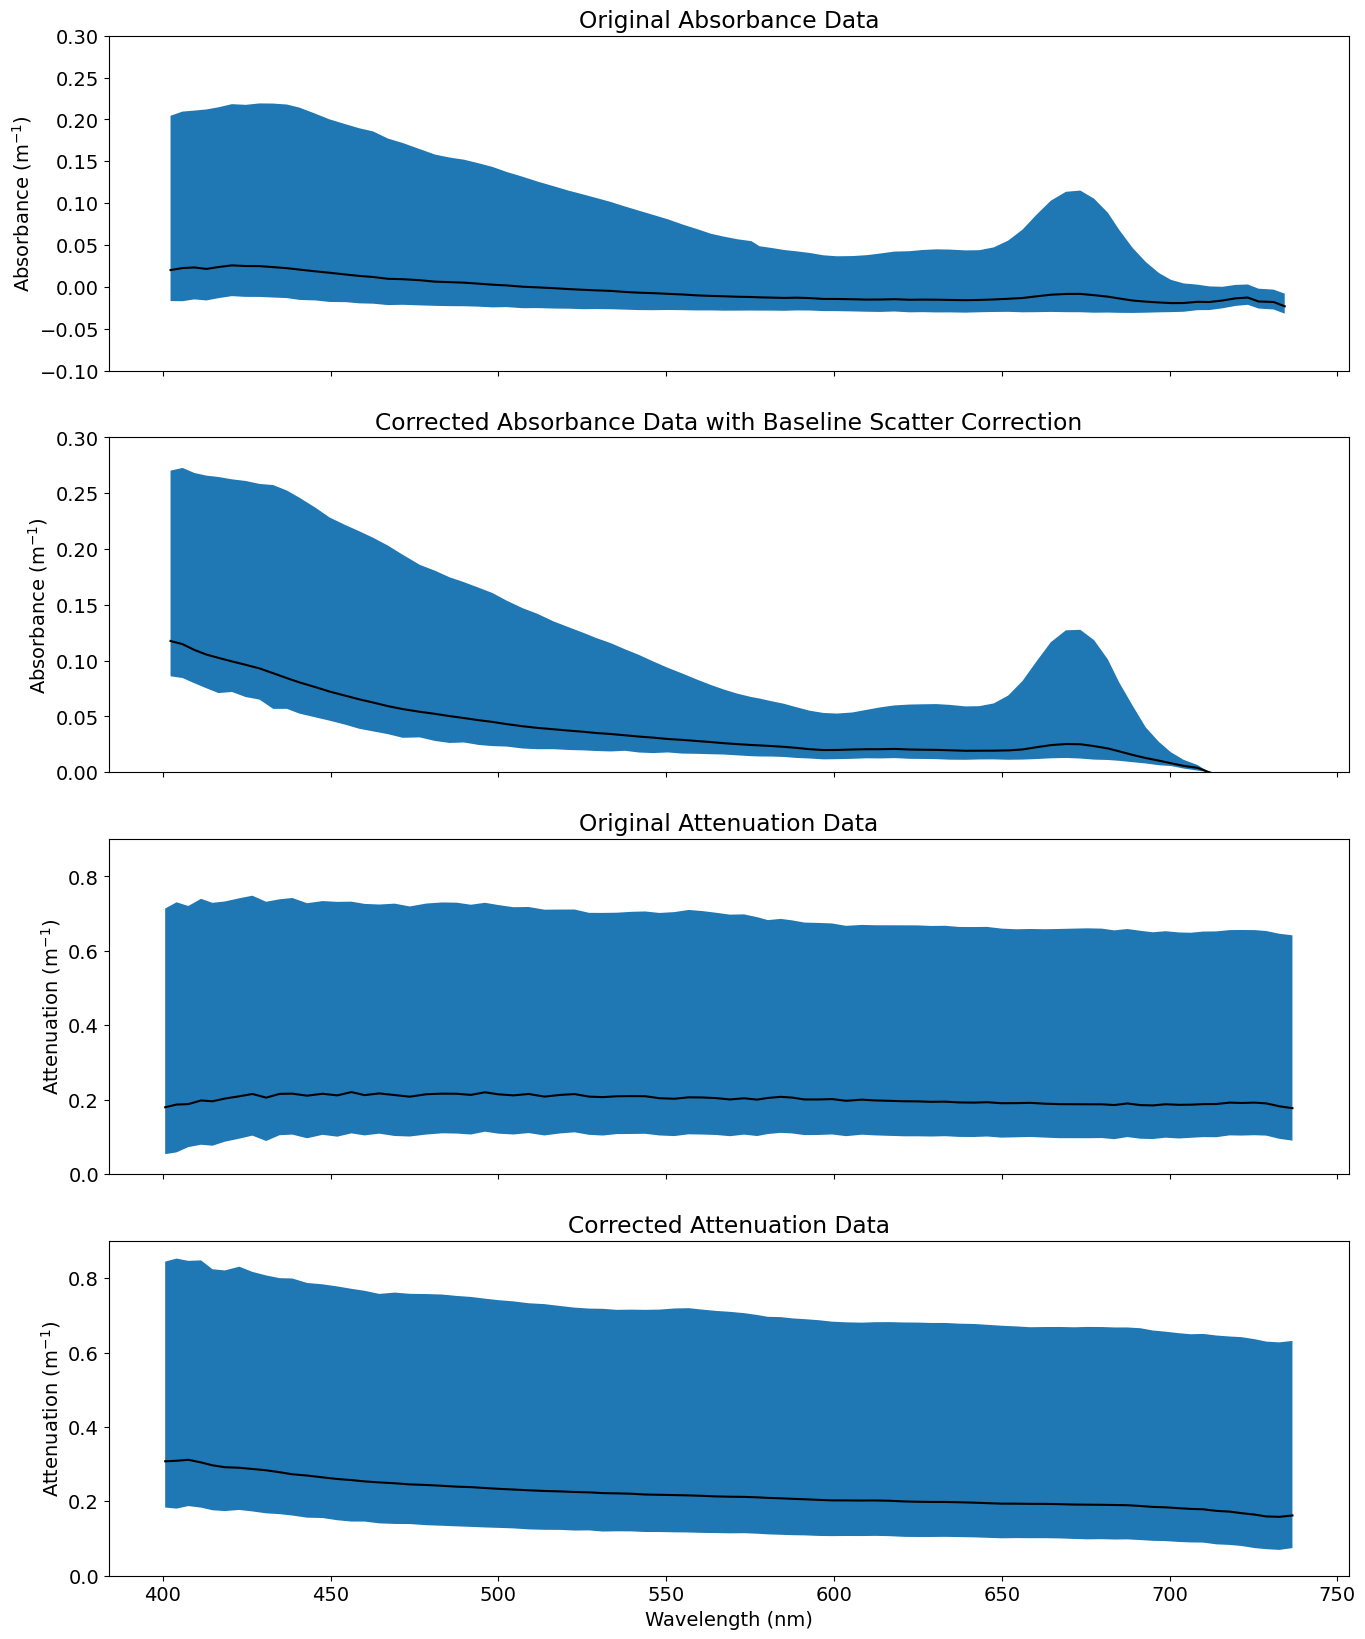

In [20]:
# re-plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here with the
# pure-water offsets applied)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(411)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].max(axis=0))
plt.ylim([-0.1, 0.30])
plt.title('Original Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apg_ts_s'].min(axis=0), 
                 profile['apg_ts_s'].max(axis=0))
plt.ylim([0, 0.30])
plt.title('Corrected Absorbance Data with Baseline Scatter Correction')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].max(axis=0))
plt.ylim([0, 0.9])
plt.title('Original Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['cpg_ts'].min(axis=0), 
                 profile['cpg_ts'].max(axis=0))
plt.ylim([0, 0.9])
plt.title('Corrected Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')

plt.show()

In [21]:
# create a slice at 10 m for the entire deployment
slice10 = optaa.where((optaa['depth'] >= 9.75) & (optaa['depth'] <= 10.25), drop=True)

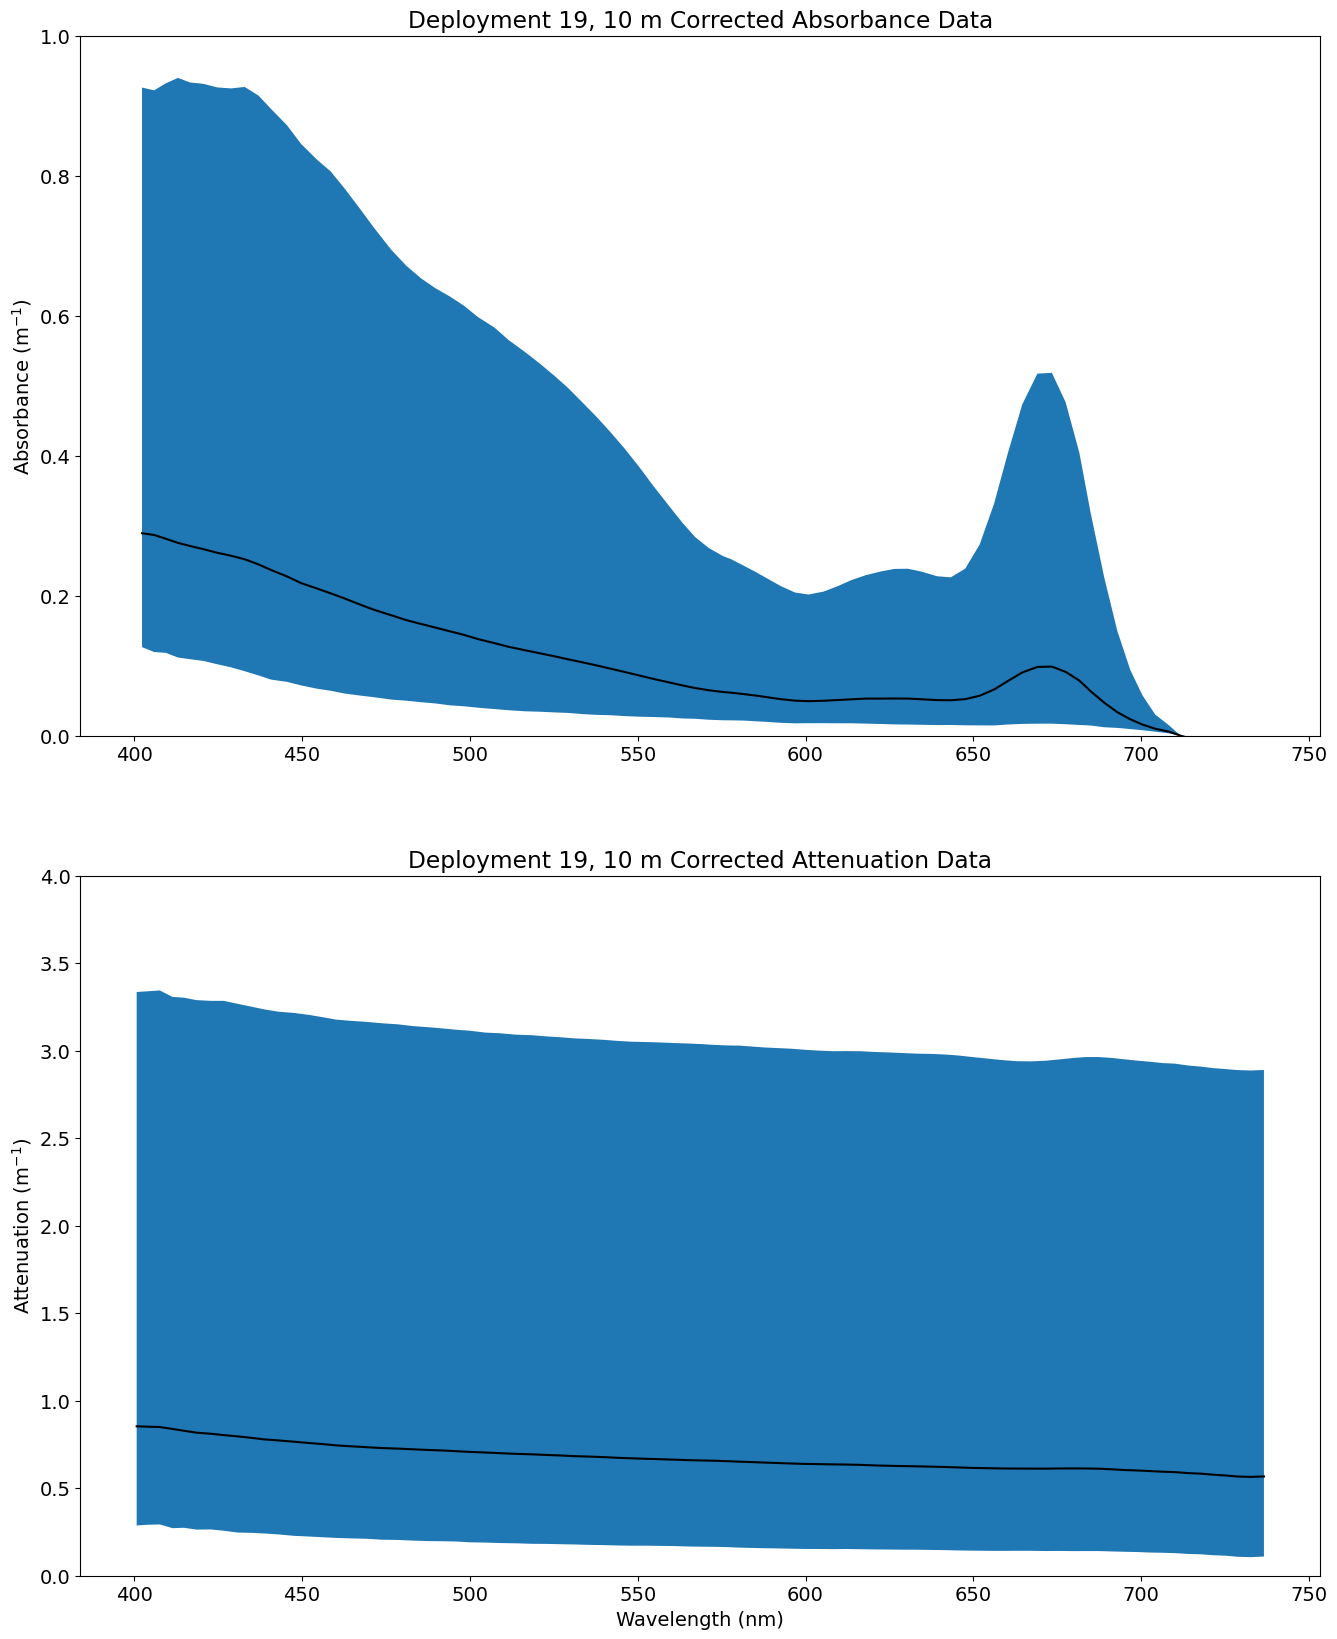

In [22]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(211)
plt.plot(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].min(axis=0), 
                 slice10['apg_ts_s'].max(axis=0))
plt.ylim([0, 1.0])
plt.title('Deployment 19, 10 m Corrected Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(slice10['wavelength_c'][0, :], slice10['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_c'][0, :], slice10['cpg_ts'].min(axis=0), 
                 slice10['cpg_ts'].max(axis=0))
plt.ylim([0, 4])
plt.title('Deployment 19, 10 m Corrected Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.show()

In [23]:
# save these results, replacing the earlier file
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')